In [3]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, concatenate, add, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image as image_utils

2021-10-28 04:09:04.710172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
def load_and_process_image(image_path, tgt_sz):
    image = image_utils.load_img(image_path, target_size=tgt_sz)
    image = image_utils.img_to_array(image)
    return image

In [5]:
ip_train_val = pd.read_csv('../input/nnfl-2021-assignment-1/fire_videos/train.csv', header=0).values
ip_test = pd.read_csv('../input/nnfl-2021-assignment-1/fire_videos/test.csv', header=0).values

target_size = (128, 128, 3)

Decisions:
* 128x128: Increasing picture size would highlight unnecessary details ...
* Data setup:
*     70k/6 = 11491
*     num_train => ~9k, num_val => ~3k
*     19 : 1 in first 4k [num_train += 3800, num_val += 200]
*     11 : 1 in next 4k [num_train += 2750, num_val += 250]
*     1 : 19 in next 1k [num_train += 50, num_val += 950]
*     1 : 2 in last 3k [num_train += 1000, num_val += 2000]

In [ ]:
ip_train_val = np.array([ip for ip in [ip_train_val[ind] for ind in range(0, ip_train_val.shape[0], 6)]])

ip_train = list(ip_train_val[ind] for ind in range(0, 4000) if ind%20!=0)+list(ip_train_val[ind] for ind in range(4000,8000) if ind%12!=0)+list(ip_train_val[ind] for ind in range(8000, 9000, 20))

ip_valid = list(ip_train_val[ind] for ind in range(0, 4000, 20))+list(ip_train_val[ind] for ind in range(4000, 8000, 12))+list(ip_train_val[ind] for ind in range(8000, 9000) if ind%20!=0)+list(ip_train_val[ind] for ind in range(9000, ip_train_val.shape[0]))

target_size = (128, 128, 3)

x_train = np.array([load_and_process_image('../input/nnfl-2021-assignment-1/fire_videos/train/' + ip[0], target_size) for ip in ip_train])/255.
y_train = np.array([int(ip[1]=="fire") for ip in ip_train])
x_valid = np.array([load_and_process_image('../input/nnfl-2021-assignment-1/fire_videos/train/' + ip[0], target_size) for ip in ip_valid])/255.
y_valid = np.array([int(ip[1]=="fire") for ip in ip_valid])
x_test = np.array([load_and_process_image('../input/nnfl-2021-assignment-1/fire_videos/test/' + ip[0], target_size) for ip in ip_test])/255.

# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=2)

In [ ]:
# with open('data12k.npy', 'wb') as f:
#     np.save(f, x_train)
#     np.save(f, y_train)
#     np.save(f, x_valid)
#     np.save(f, y_valid)
#     np.save(f, x_test)

In [5]:
with open('../input/new-data/data12k.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)
    x_valid = np.load(f)
    y_valid = np.load(f)
    x_test = np.load(f)

In [ ]:
# print(x_train.shape)
# print(x_valid.shape)
# print(y_train.shape)
# print(y_valid.shape)
# plt.imshow(x_train[0], cmap = 'gray')
# print(y_train[0])

In [2]:
def residual_module(layer_in, n_filters):

    merge_input = layer_in
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    layer_out = add([conv2, merge_input])
    layer_out = Activation('relu')(layer_out)
 
    return layer_out

In [ ]:
def inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [3]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, min_lr=0.0001)
callbacks = [learning_rate_reduction]

In [12]:
target_size = (128, 128, 3)
inp = Input(x_train[0].shape)
# conv layers
convOut = residual_module(inp, 64)
convOut = MaxPool2D((2, 2))(convOut)
convOut = residual_module(convOut, 128)
convOut = MaxPool2D((2, 2))(convOut)
convOut = Conv2D(128, (3, 3), padding='valid', activation='relu', input_shape=target_size)(convOut)
# convOut = Conv2D(256, (3, 3), padding='valid', activation='relu', input_shape=target_size)(convOut)
convOut = residual_module(convOut, 64)
convOut = MaxPool2D((2, 2))(convOut)
#flatten
flatOut = Flatten()(convOut)
# dense layers
denseOut = Dense(1024, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01))(flatOut)
denseOut = Dropout(0.1)(denseOut)
denseOut = Dense(512, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01))(denseOut)
denseOut = Dropout(0.1)(denseOut)
denseOut = Dense(64, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01))(denseOut)
denseOut = Dropout(0.1)(denseOut)
out = Dense(1, activation="sigmoid")(denseOut)

model = Model(inputs = inp, outputs = out)
# optimizer='adam'
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = ['accuracy']) ## metrics
print(model.summary())

## Residul models, inception layers, callbacks (early stopping, reduce lr on plateau), regularisation

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 64) 256         input_4[0][0]                    
____________________________________________________________________________________________

In [13]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=16, callbacks = callbacks)

2021-10-28 03:58:45.440853: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1641283584 exceeds 10% of free system memory.


Epoch 1/10
522/522 [==============================] - 20s 36ms/step - loss: 9.2547 - accuracy: 0.8228 - val_loss: 0.7589 - val_accuracy: 0.9701
Epoch 2/10
522/522 [==============================] - 18s 34ms/step - loss: 0.5531 - accuracy: 0.9733 - val_loss: 0.2492 - val_accuracy: 0.9806
Epoch 3/10
522/522 [==============================] - 18s 34ms/step - loss: 0.2074 - accuracy: 0.9846 - val_loss: 0.1207 - val_accuracy: 0.9917
Epoch 4/10
522/522 [==============================] - 18s 34ms/step - loss: 0.1140 - accuracy: 0.9915 - val_loss: 0.0985 - val_accuracy: 0.9898
Epoch 5/10
522/522 [==============================] - 18s 34ms/step - loss: 0.0959 - accuracy: 0.9928 - val_loss: 0.1141 - val_accuracy: 0.9828

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
522/522 [==============================] - 17s 34ms/step - loss: 0.0545 - accuracy: 0.9978 - val_loss: 0.0762 - val_accuracy: 0.9905
Epoch 7/10
522/522 [==============================] - 

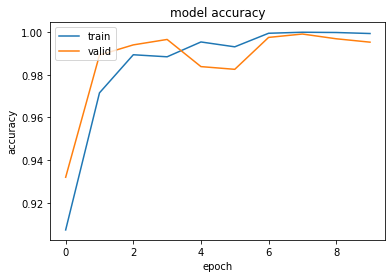

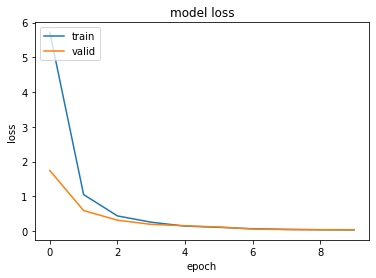

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
ip_test = pd.read_csv('../input/nnfl-2021-assignment-1/fire_videos/test.csv', header=0).values

with open('sample_output_actual.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['File', 'Label'])
    cnt = 0
    for item in x_test:
        prediction = model.predict(item.reshape(-1, 128, 128, 3))
        st = 'fire'
        if (prediction[0] < 0.5):
            st = 'not_fire'
        writer.writerow([ip_test[cnt][0], st])
        cnt += 1